In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv('resamp_training_data.csv')

X_train_resampled = train_data.drop(columns=['stroke'])
y_train_resampled = train_data['stroke']

test_data = pd.read_csv('resamp_test_data.csv')
X_test = test_data.drop(columns=['stroke'])
y_test = test_data['stroke']

<font color="bluegrey" size=+1.0><b>Adaptive Gradient Boosting (XGBoost + LightGBM)</b></font>

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\xgboost\core.py:158: UserWarning: [07:24:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3655, number of negative: 3261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3183
[LightGBM] [Info] Number of data points in the train set: 6916, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528485 -> initscore=0.114062
[LightGBM] [Info] Start training from score 0.114062


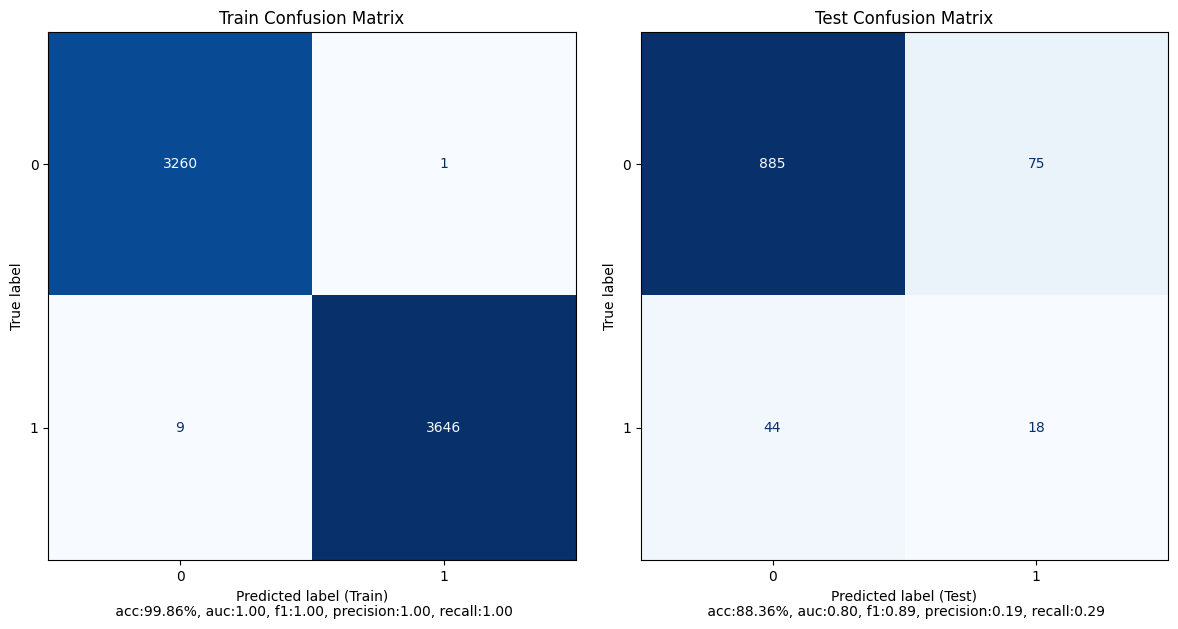

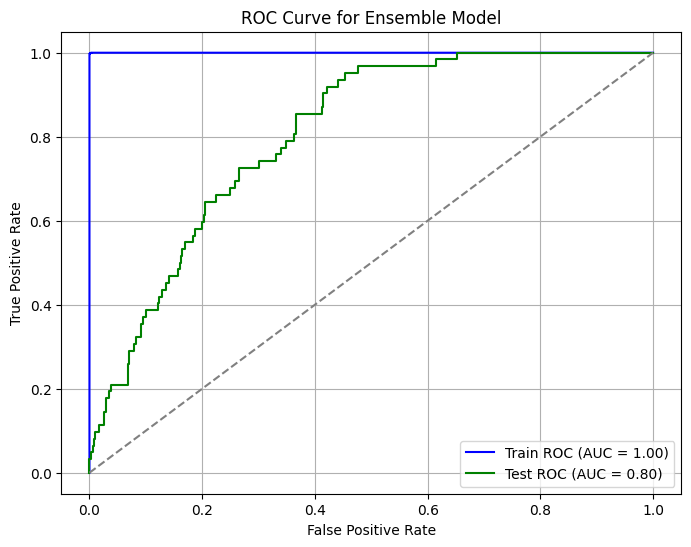

Ensemble Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       960
           1       0.19      0.29      0.23        62

    accuracy                           0.88      1022
   macro avg       0.57      0.61      0.58      1022
weighted avg       0.91      0.88      0.89      1022

Training Accuracy: 0.9986
Training ROC AUC Score: 1.0000
Test Accuracy: 0.8836
Test ROC AUC Score: 0.8048


In [4]:
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
lgbm_model = LGBMClassifier(random_state=42, is_unbalance=True)

xgb_model.fit(X_train_resampled, y_train_resampled)
lgbm_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities
xgb_train_pred = xgb_model.predict_proba(X_train_resampled)[:, 1]
lgbm_train_pred = lgbm_model.predict_proba(X_train_resampled)[:, 1]
ensemble_train_pred = (xgb_train_pred + lgbm_train_pred) / 2
ensemble_train_binary = (ensemble_train_pred >= 0.5).astype(int)

xgb_test_pred = xgb_model.predict_proba(X_test)[:, 1]
lgbm_test_pred = lgbm_model.predict_proba(X_test)[:, 1]
ensemble_test_pred = (xgb_test_pred + lgbm_test_pred) / 2
ensemble_test_binary = (ensemble_test_pred >= 0.5).astype(int)

#train set
train_accuracy = accuracy_score(y_train_resampled, ensemble_train_binary)
train_roc_auc = roc_auc_score(y_train_resampled, ensemble_train_pred)
train_f1_weighted = f1_score(y_train_resampled, ensemble_train_binary, average='weighted')
train_precision = precision_score(y_train_resampled, ensemble_train_binary)
train_recall = recall_score(y_train_resampled, ensemble_train_binary)

#test set
test_accuracy = accuracy_score(y_test, ensemble_test_binary)
test_roc_auc = roc_auc_score(y_test, ensemble_test_pred)
test_f1_weighted = f1_score(y_test, ensemble_test_binary, average='weighted')
test_precision = precision_score(y_test, ensemble_test_binary)
test_recall = recall_score(y_test, ensemble_test_binary)

# Confusion matrix plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cm_train = confusion_matrix(y_train_resampled, ensemble_train_binary)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_xlabel(f"Predicted label (Train)\n acc:{train_accuracy*100:.2f}%, auc:{train_roc_auc:.2f}, f1:{train_f1_weighted:.2f}, precision:{train_precision:.2f}, recall:{train_recall:.2f}")
axes[0].set_title('Train Confusion Matrix')

cm_test = confusion_matrix(y_test, ensemble_test_binary)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap='Blues', ax=axes[1], colorbar=False)
axes[1].set_xlabel(f"Predicted label (Test)\n acc:{test_accuracy*100:.2f}%, auc:{test_roc_auc:.2f}, f1:{test_f1_weighted:.2f}, precision:{test_precision:.2f}, recall:{test_recall:.2f}")
axes[1].set_title('Test Confusion Matrix')

plt.tight_layout()

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, ensemble_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, ensemble_test_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC (AUC = {train_roc_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC (AUC = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Classification report
print("Ensemble Model Performance on Test Set:")
print(classification_report(y_test, ensemble_test_binary))

# Summary
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training ROC AUC Score: {train_roc_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC Score: {test_roc_auc:.4f}")

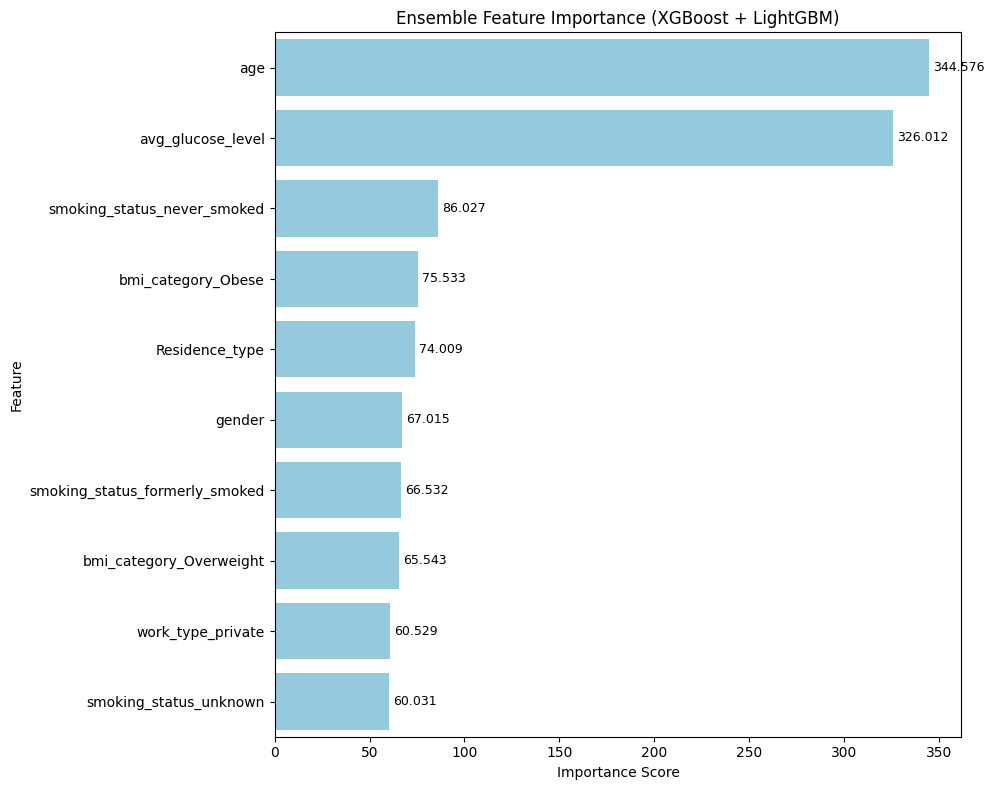

In [5]:
xgb_importance = xgb_model.feature_importances_
lgbm_importance = lgbm_model.feature_importances_
combined_importance = (xgb_importance + lgbm_importance) / 2

feature_names = X_train_resampled.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Combined Importance': combined_importance
}).sort_values(by='Combined Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='Combined Importance', y='Feature', data=importance_df.head(10), color='skyblue')

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.3f", label_type='edge', padding=3, fontsize=9)

plt.title("Ensemble Feature Importance (XGBoost + LightGBM)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

<font color="bluegrey" size=+1.0><b>Save results</b></font>

In [6]:
results = {
    "Model": ["XGBoost + LightGBM Ensemble"],
    "Accuracy": [accuracy_score(y_test, ensemble_test_binary)],
    "ROC AUC": [roc_auc_score(y_test, ensemble_test_pred)]
}

results_df = pd.DataFrame(results)
print(results_df)

                         Model  Accuracy   ROC AUC
0  XGBoost + LightGBM Ensemble  0.883562  0.804755


<font color="bluegrey" size=+1.0><b>Save models</b></font>

In [7]:
from joblib import dump

dump(xgb_model, 'XGBoost_model.pkl')
dump(lgbm_model, 'lightgbm_model.pkl')

# ensemble logic as a custom function
def ensemble_predict(X):
    """
    Function to predict using the XGBoost and LightGBM ensemble.
    Averages the probabilities from both models.
    """
    xgb_pred = xgb_model.predict_proba(X)[:, 1]
    lgbm_pred = lgbm_model.predict_proba(X)[:, 1]
    ensemble_pred = (xgb_pred + lgbm_pred) / 2
    return ensemble_pred

dump(ensemble_predict, 'ensemble_model.pkl')
print("Successfully saved the model.")


Successfully saved the model.
